# Module usage example  
Simulation pipiline using Jupyter notebook  

The steps are:
1. Libraries Importing 
1. Data
    1. Importing
    1. Selecting
1. Simulation
    1. Initializing components
    1. Running simulations
    1. Plotting results
1. Simulation Metrics

# Imports

In [2]:
from railtemp.railtemp import * #import all classes and functions from railtemp repository
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px 
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

%config Completer.use_jedi = False
%matplotlib inline

# Data

## Data Import  
The data source can be any format, since it can be transformed to `pandas` data frame.  
This example will read a example file `data.csv`.  
The data contains the following headers:  
*  RT1: measured rail temperature for further comparisions
* TA: air temperature in Celsius
* SR: solar radiation in W/m²
* Wv_avg: average wind speed in m/s

In [3]:
df = pd.read_csv('examples/data.csv') #import csv file

In [4]:
df.head()

,Date,RT1,TA,SR,Wv_avg
0,2020/08/09 06:00:00,24.189,20.55713,0.05597,0.32539
1,2020/08/09 06:05:00,24.060,20.45899,0.22490,0.00000
2,2020/08/09 06:10:00,23.990,20.39551,0.64481,0.00000
3,2020/08/09 06:15:00,23.924,20.47071,1.48352,0.00000
4,2020/08/09 06:20:00,23.860,20.55078,2.41260,0.00000


In order to work properly, the dataframe index must be `DatetimeIndex`

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205 entries, 2020-08-09 06:00:00 to 2020-08-09 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RT1     205 non-null    float64
 1   TA      205 non-null    float64
 2   SR      205 non-null    float64
 3   Wv_avg  205 non-null    float64
dtypes: float64(4)
memory usage: 8.0 KB


# Data Selecting

Ploting the dataframe help analyzing if there is any missing or anormal value

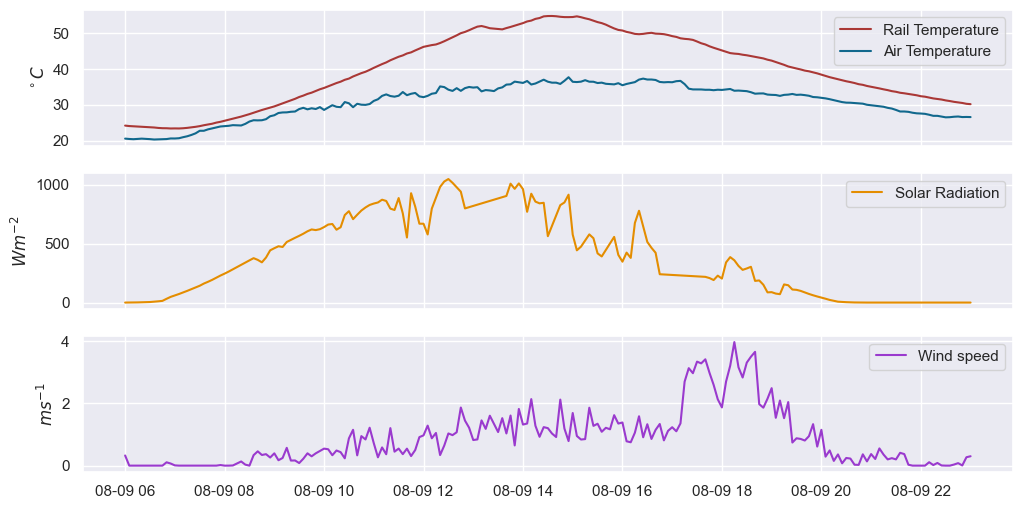

In [7]:
sns.set_theme()
fig, axes = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(12,6))
axes[0].plot(df.index,df['RT1'],label='Rail Temperature',color='#AA3836')
axes[0].plot(df.index,df['TA'],label='Air Temperature',color='#11688D')
axes[0].set_ylabel('$^\circ C$')
axes[0].legend()

axes[1].plot(df.index,df['SR'],label='Solar Radiation',color='#E48D00')
axes[1].set_ylabel('$Wm^{-2}$')
axes[1].legend()

axes[2].plot(df.index,df['Wv_avg'],label='Wind speed',color='#9A3ACE')
axes[2].set_ylabel('$ms^{-1}$')
axes[2].legend()

As seen, the data is clear with no fault or missing values.  
The range is from 06:00 to 23:00 of 2020-08-09. 
This will be the total range of the simulation  
It's very important that **missing values** are not passed to the simulation, otherwise it will not run properly.

# Simulation

## Initializing components

First is necessary to define `RailMaterial` object in which contains material properties to later be assigned to a `Rail` object.  
The parameters are:
* Density in kg/m³
* solar absortion 
* emisivity 

In [8]:
steel = RailMaterial(density=7850,solar_absort=0.8,emissivity=0.7)

Now we need to create a `Rail` objected which will pack many information of the rail to be simulated, such as:  
* Section name
* Azimuth
* Position (lat,long, elevation)
* Cross section area
* convection, radiation areas
* ambient emissivity
* material property  

The list of availiable sections can be found in xxxxxxx.  

The position has to be in decimal degrees, in this example is in the city of Mirandela-Portugal.  

The input areas must be in m².  

The material property is the `RailMaterial` object in which we created before

In [9]:
UIC54 = Rail(name='UIC54',
             azimuth=93,lat=41.482628,long=-7.183741,elev=220,
             cross_area=7.16e-3,convection_area=430.46e-3,radiation_area=430.46e-3,
             ambient_emissivity=0.5,material=steel)

Now is necessary to create a `WeatherData` object which packs:
* Solar radiation
* Wind velocity
* Ambient temperature
* Timezone information

Timzone information must be a `pytz.Timzone` object.  

We will use the dataframe `df` which we imported before. Each column will be a parameter of the `WeatherData` class initialization. It is imporant to mention that the dataframe must have the same `DateTimeIndex` to assure a issuless simulation run.



In [10]:
day1 = WeatherData(solar_radiation=df['SR'],
                   wind_velocity=df['Wv_avg'],
                   ambient_temperature=df['TA'],
                   timezone=pytz.timezone('Europe/Lisbon'))

The last object we need to create is a `CNU` object, which contains the methods to perform and output the solution.  
To create is necessary to pass the forementioned objects: `UIC54` which have the material and geometry info and `day1` that have all the datetime and ambient information.  

In [11]:
simu1 = CNU(rail=UIC54,weather=day1)

Once the `CNU` object is created, simply call the method `CNU.run` to run the simulation.

The only parameter needed is the initial rail temperature in Celsius.  
After, the programm will do all the calculations and the result will be availiable on `CNU.result`

## Running simulation

In [12]:
simu1.run_original_CNU_area(Trail_initial=23)

Converting the temperatures to Kelvin
Done
Calculating Hconv
Done
Fetching solar data
Done
Calculating As
Done
Creating Delta time Columns
Done
Setting initial conditions
Done
Solving model
Done
Converting temperatures to Celsius
Done
Finished in: 2024-04-11 23:35:13.417019
Execution time: 1.350423812866211
------------------------------------


In [13]:
simu1.result

,SR,Tamb,Wv,Hconv,Sun_azimuth,Sun_altitude,As,Delta_time,Simu_time,Tr_simu
Date,,,,,,,,,,
2020-08-09 06:00:00,0.05597,20.55713,0.32539,6.90156,62.590718,-6.237633,0.0,0,0,23.000000
2020-08-09 06:05:00,0.22490,20.45899,0.00000,5.60000,63.462800,-5.403704,0.0,300,300,22.902975
2020-08-09 06:10:00,0.64481,20.39551,0.00000,5.60000,64.327517,-4.563428,0.0,300,600,22.807237
2020-08-09 06:15:00,1.48352,20.47071,0.00000,5.60000,65.185217,-3.717048,0.0,300,900,22.718015
2020-08-09 06:20:00,2.41260,20.55078,0.00000,5.60000,66.036247,-2.864801,0.0,300,1200,22.635247
...,...,...,...,...,...,...,...,...,...,...
2020-08-09 22:40:00,0.00000,26.65577,0.03462,5.73848,314.989908,-20.263250,0.0,300,60000,29.925761
2020-08-09 22:45:00,0.00000,26.72022,0.07996,5.91984,316.068484,-20.920188,0.0,300,60300,29.797620
2020-08-09 22:50:00,0.00000,26.56690,0.00543,5.62172,317.160549,-21.564357,0.0,300,60600,29.673069


## Plotting results

Joining the df and result dataframes to ease the plot

In [14]:
result = simu1.result
result = result.join(df['RT1'])

In [15]:
result.head()

,SR,Tamb,Wv,Hconv,Sun_azimuth,Sun_altitude,As,Delta_time,Simu_time,Tr_simu,RT1
Date,,,,,,,,,,,
2020-08-09 06:00:00,0.05597,20.55713,0.32539,6.90156,62.590718,-6.237633,0.0,0,0,23.000000,24.189
2020-08-09 06:05:00,0.22490,20.45899,0.00000,5.60000,63.462800,-5.403704,0.0,300,300,22.902975,24.060
2020-08-09 06:10:00,0.64481,20.39551,0.00000,5.60000,64.327517,-4.563428,0.0,300,600,22.807237,23.990
2020-08-09 06:15:00,1.48352,20.47071,0.00000,5.60000,65.185217,-3.717048,0.0,300,900,22.718015,23.924
2020-08-09 06:20:00,2.41260,20.55078,0.00000,5.60000,66.036247,-2.864801,0.0,300,1200,22.635247,23.860


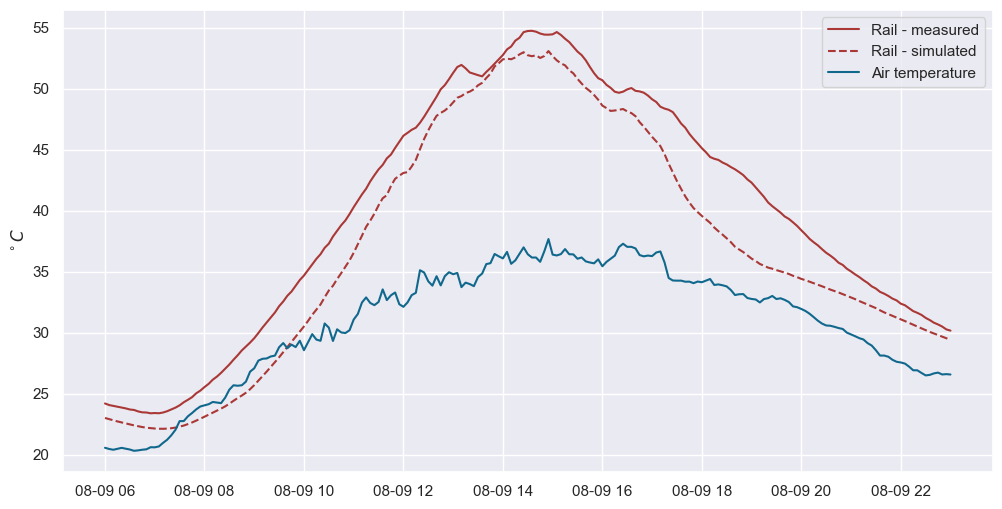

In [16]:
data = result
sns.set_theme()
fig, axes = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(12,6))

axes.plot(data.index,data['RT1'],label='Rail - measured',color='#AA3836')
axes.plot(data.index,data['Tr_simu'],label='Rail - simulated',color='#AA3836',ls='--')
axes.plot(df.index,df['TA'],label='Air temperature',color='#11688D')
axes.set_ylabel('$^\circ C$')
axes.legend()

# Simulation metrics

In [17]:
from sklearn.metrics import max_error,r2_score,mean_squared_error

In [18]:
data = result

In [19]:
print('n. of samples: ' + str(len(data)))
print('r2: ' + str(r2_score(data['RT1'],data['Tr_simu'])))
print('max error: '+str(max_error(data['RT1'],data['Tr_simu'])))
print('RMSE: '+str(mean_squared_error(data['RT1'],data['Tr_simu'])))

n. of samples: 205
r2: 0.8944029260253776
max error: 6.347271488906124
RMSE: 10.2256172504268


<Axes: xlabel='RT1', ylabel='Tr_simu'>

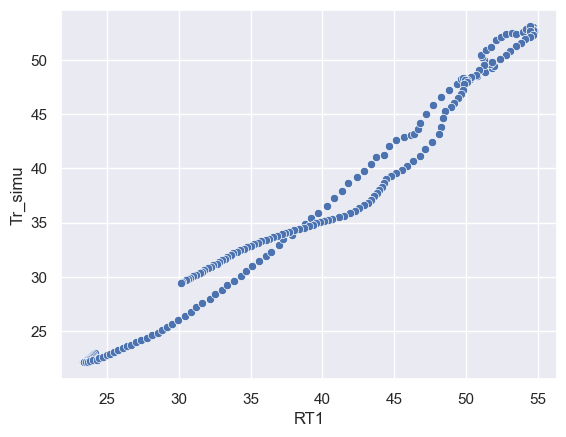

In [20]:
sns.scatterplot(x=data['RT1'],y=data['Tr_simu'])